<h1> Time series prediction using RNNs with TensorFlow </h1>

This notebook illustrates:
<ol>
<li> Creating a Recurrent Neural Network in TensorFlow
<li> Creating a Custom Estimator in tf.estimator
</ol>

<p>

<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [ ]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [83]:
!pip install tensorflow==1.15.3

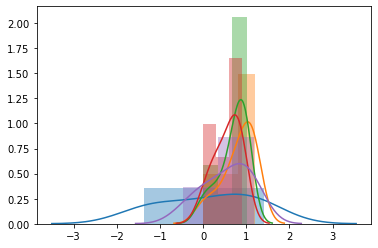

In [84]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf

SEQ_LEN = 10
def create_time_series():
  freq = (np.random.random() * 0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  x = np.sin(np.arange(0, SEQ_LEN) * freq) * ampl
  return x

for i in range(0, 5):
  sns.distplot( create_time_series() );  # 5 series

In [85]:
def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in range(0, N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

to_csv('train.csv', 1000)  # 1000 sequences
to_csv('valid.csv',  50)

In [86]:
!head -5 train.csv valid.csv

==> train.csv <==
0.0,0.22299305220216323,0.4154388426580984,0.5509747027780788,0.6110339133114452,0.5873891128838562,0.48327934370073466,0.31296634323851563,0.09978086441764555,-0.12707334601853693
0.0,0.15901002275298337,0.312416176599827,0.4548120855104597,0.5811793991162043,0.6870646506027852,0.7687362068432376,0.8233157794969398,0.8488798623294476,0.8445275198750664
0.0,0.1393968329251676,0.2703258427596177,0.38483359419599195,0.47596418040820354,0.5381817677190796,0.5677068762693995,0.5627459689271358,0.5236004017910049,0.452648117963003
0.0,0.224754084492425,0.4198144336661288,0.5594103462116253,0.625098891100264,0.6082015240920136,0.5109506671010717,0.3461947683037169,0.13570080943082635,-0.09272147286664245
0.0,0.141784381770469,0.28206183491143016,0.4193414469008347,0.5521641672073662,0.6791183145345397,0.7988545806098002,0.910100371053667,1.0116733309097004,1.1024939110817333

==> valid.csv <==
0.0,0.42040678054096164,0.7119890871863938,0.7853978918294988,0.6181386699402988,

<h2> RNN </h2>

For more info, see:
<ol>
<li> http://colah.github.io/posts/2015-08-Understanding-LSTMs/ for the theory
<li> https://www.tensorflow.org/tutorials/recurrent for explanations
<li> https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb for sample code
</ol>

Here, we are trying to predict from 9 values of a timeseries, the tenth value.

<p>

<h3> Imports </h3>

Several tensorflow packages and shutil

In [88]:
import shutil
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

<h3> Input Fn to read CSV </h3>

Our CSV file structure is quite simple -- a bunch of floating point numbers (note the type of DEFAULTS). We ask for the data to be read BATCH_SIZE sequences at a time.  The Estimator API in tf.contrib.learn wants the features returned as a dict. We'll just call this timeseries column 'rawdata'.
<p>
Our CSV file sequences consist of 10 numbers. We'll assume that 9 of them are inputs and we need to predict the last one.

In [89]:
DEFAULTS = [[0.0] for x in range(0, SEQ_LEN)]
BATCH_SIZE = 20
TIMESERIES_COL = 'rawdata'
# In each sequence, column index 0 to N_INPUTS - 1 are features, and column index N_INPUTS to SEQ_LEN are labels
N_OUTPUTS = 1
N_INPUTS = SEQ_LEN - N_OUTPUTS

Reading data using the Estimator API in tf.estimator requires an input_fn. This input_fn needs to return a dict of features and the corresponding labels.
<p>
So, we read the CSV file.  The Tensor format here will be a scalar -- entire line.  We then decode the CSV. At this point, all_data will contain a list of scalar Tensors. There will be SEQ_LEN of these tensors.
<p>
We split this list of SEQ_LEN tensors into a list of N_INPUTS Tensors and a list of N_OUTPUTS Tensors. We stack them along the first dimension to then get a vector Tensor for each.  We then put the inputs into a dict and call it features.  The other is the ground truth, so labels.

In [90]:
# Read data and convert to needed format
def read_dataset(filename, mode, batch_size = 512):
  def _input_fn():
    # Provide the ability to decode a CSV
    def decode_csv(line):
      # all_data is a list of scalar tensors
      all_data = tf.decode_csv(line, record_defaults = DEFAULTS)
      inputs = all_data[:len(all_data) - N_OUTPUTS]  # first N_INPUTS values
      labels = all_data[len(all_data) - N_OUTPUTS:] # last N_OUTPUTS values

      # Convert each list of rank R tensors to one rank R+1 tensor
      inputs = tf.stack(inputs, axis = 0)
      labels = tf.stack(labels, axis = 0)
      
      # Convert input R+1 tensor into a feature dictionary of one R+1 tensor
      features = {TIMESERIES_COL: inputs}

      return features, labels

    # Create list of files that match pattern
    file_list = tf.gfile.Glob(filename)

    # Create dataset from file list
    dataset = tf.data.TextLineDataset(file_list).map(decode_csv)

    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # indefinitely
        dataset = dataset.shuffle(buffer_size = 10 * batch_size)
    else:
        num_epochs = 1 # end-of-input after this

    dataset = dataset.repeat(num_epochs).batch(batch_size)

    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels
  return _input_fn

<h3> Define RNN </h3>

A recursive neural network consists of possibly stacked LSTM cells.
<p>
The RNN has one output per input, so it will have 8 output cells.  We use only the last output cell, but rather use it directly, we do a matrix multiplication of that cell by a set of weights to get the actual predictions. This allows for a degree of scaling between inputs and predictions if necessary (we don't really need it in this problem).
<p>
Finally, to supply a model function to the Estimator API, you need to return a EstimatorSpec. The rest of the function creates the necessary objects.

In [91]:
LSTM_SIZE = 3  # number of hidden layers in each of the LSTM cells

# Create the inference model
def simple_rnn(features, labels, mode):
  # 0. Reformat input shape to become a sequence
  x = tf.split(features[TIMESERIES_COL], N_INPUTS, 1)
    
  # 1. Configure the RNN
  lstm_cell = rnn.BasicLSTMCell(LSTM_SIZE, forget_bias = 1.0)
  outputs, _ = rnn.static_rnn(lstm_cell, x, dtype = tf.float32)

  # Slice to keep only the last cell of the RNN
  outputs = outputs[-1]
  
  # Output is result of linear activation of last layer of RNN
  weight = tf.get_variable("weight", initializer=tf.initializers.random_normal, shape=[LSTM_SIZE, N_OUTPUTS])
  bias = tf.get_variable("bias", initializer=tf.initializers.random_normal, shape=[N_OUTPUTS])
  predictions = tf.matmul(outputs, weight) + bias
    
  # 2. Loss function, training/eval ops
  if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
    loss = tf.losses.mean_squared_error(labels, predictions)
    train_op = tf.contrib.layers.optimize_loss(
      loss = loss,
      global_step = tf.train.get_global_step(),
      learning_rate = 0.01,
      optimizer = "SGD")
    eval_metric_ops = {
      "rmse": tf.metrics.root_mean_squared_error(labels, predictions)
    }
  else:
    loss = None
    train_op = None
    eval_metric_ops = None
  
  # 3. Create predictions
  predictions_dict = {"predicted": predictions}
  
  # 4. Create export outputs
  export_outputs = {"predict_export_outputs": tf.estimator.export.PredictOutput(outputs = predictions)}
  
  # 5. Return EstimatorSpec
  return tf.estimator.EstimatorSpec(
      mode = mode,
      predictions = predictions_dict,
      loss = loss,
      train_op = train_op,
      eval_metric_ops = eval_metric_ops,
      export_outputs = export_outputs)

<h3> Estimator </h3>

Distributed training is launched off using an Estimator.  The key line here is that we use tf.estimator.Estimator rather than, say tf.estimator.DNNRegressor.  This allows us to provide a model_fn, which will be our RNN defined above.  Note also that we specify a serving_input_fn -- this is how we parse the input data provided to us at prediction time.

In [92]:
# Create functions to read in respective datasets
def get_train():
  return read_dataset(filename = 'train.csv', mode = tf.estimator.ModeKeys.TRAIN, batch_size = 512)

def get_valid():
  return read_dataset(filename = 'valid.csv', mode = tf.estimator.ModeKeys.EVAL, batch_size = 512)

In [93]:
# Create serving input function
def serving_input_fn():
  feature_placeholders = {
      TIMESERIES_COL: tf.placeholder(tf.float32, [None, N_INPUTS])
  }
  
  features = {
    key: tf.expand_dims(tensor, -1)
    for key, tensor in feature_placeholders.items()
  }
  features[TIMESERIES_COL] = tf.squeeze(features[TIMESERIES_COL], axis = [2])
    
  return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

In [94]:
# Create custom estimator's train and evaluate function
def train_and_evaluate(output_dir):
  estimator = tf.estimator.Estimator(model_fn = simple_rnn, 
                         model_dir = output_dir)
  train_spec = tf.estimator.TrainSpec(input_fn = get_train(),
                                    max_steps = 1000)
  exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(input_fn = get_valid(),
                                  steps = None,
                                  exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [95]:
# Run the model
shutil.rmtree('outputdir', ignore_errors = True) # start fresh each time
train_and_evaluate('outputdir')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'outputdir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5b6e7b4a50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorfl

<h3> Standalone Python module </h3>

To train this on Cloud ML Engine, we take the code in this notebook and make a standalone Python module.

In [96]:
%%bash
# Run module as-is
echo $PWD
rm -rf outputdir
export PYTHONPATH=${PYTHONPATH}:${PWD}/simplernn
python -m trainer.task \
  --train_data_paths="${PWD}/train.csv*" \
  --eval_data_paths="${PWD}/valid.csv*"  \
  --output_dir=outputdir \
  --job-dir=./tmp

Process is terminated.


<h2> Variant: long sequence </h2>

To create short sequences from a very long sequence.

In [98]:
import tensorflow as tf
import numpy as np

def breakup(sess, x, lookback_len):
  N = sess.run(tf.size(x))
  windows = [tf.slice(x, [b], [lookback_len]) for b in range(0, N-lookback_len)]
  windows = tf.stack(windows)
  return windows

x = tf.constant(np.arange(1,11, dtype=np.float32))
with tf.Session() as sess:
    print('input=', x.eval())
    seqx = breakup(sess, x, 5)
    print('output=', seqx.eval())

input= [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
output= [[1. 2. 3. 4. 5.]
 [2. 3. 4. 5. 6.]
 [3. 4. 5. 6. 7.]
 [4. 5. 6. 7. 8.]
 [5. 6. 7. 8. 9.]]


## Variant: Keras

You can also invoke a Keras model from within the Estimator framework by creating an estimator from the compiled Keras model:

In [101]:
def make_keras_estimator(output_dir):
  from tensorflow import keras
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(32, input_shape=(N_INPUTS,), name=TIMESERIES_INPUT_LAYER))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.Dense(1))
  model.compile(loss = 'mean_squared_error',
                optimizer = 'adam',
                metrics = ['mae', 'mape']) # mean absolute [percentage] error
  return keras.estimator.model_to_estimator(model)

In [102]:
%%bash
# Run module as-is
echo $PWD
rm -rf outputdir
export PYTHONPATH=${PYTHONPATH}:${PWD}/simplernn
python -m trainer.task \
  --train_data_paths="${PWD}/train.csv*" \
  --eval_data_paths="${PWD}/valid.csv*"  \
  --output_dir=${PWD}/outputdir \
  --job-dir=./tmp --keras

/home/jupyter/training-data-analyst/courses/machine_learning/deepdive/05_artandscience


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
2020-05-31 02:51:45.233162: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-05-31 02:51:45.239630: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2020-05-31 02:51:45.240159: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563bc8efb0d0 initialized for platform Host (this does not guarantee that XLA will be u

## Challenge Excercise
Given the trainer code provided in the simplernn folder, make a call to AI Platform using the gcloud command to train the model in the Cloud.

In [ ]:
%%bash
gcloud ai-platform "TODO: Insert code here with all the neeed parameters"

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License